# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import pandas as pd
import torch
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

from loguru import logger
logger.remove()  # Remove any default sinks set up automatically

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import synthcity.logger as log
import sys
import json

log.remove()  # Remove default handlers
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/hivae/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control = pd.read_csv(data_file_control, header=None, names=aids_control_fnames)
print(aids_control.head())

   time  censor  strat2  sex  raceth  ivdrug  karnof    cd4  priorzdv  age
0   189       0       1    1       1       0     100  169.0      39.0   34
1   287       0       1    2       2       0      90  149.5      15.0   34
2   199       0       1    1       1       0      90   46.0      53.0   48
3   270       0       1    1       2       0     100   54.5       6.0   51
4   276       0       1    1       1       0     100   95.0       7.0   34


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=aids_control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=aids_control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)


## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}
best_params_dict = {}
study_dict = {}

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Hyperparameters optimization

- The next 3 cells can be long to run, so it can be run with the code 'aids_hyperparam_optim.py' in a terminal, which will save the optuna studies and the best hyperparameter sets for the three methods. 

In [ ]:
# Surv-GAN hyperparameter search: the files best_params_aids_Surv-GAN.json and optuna_study_aids_Surv-GAN.db will be created and saved

best_params_survgan, study_survgan = generators_dict["Surv-GAN"].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=aids_control_fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_sample=50, 
                                                                                            n_splits=5,
                                                                                            n_trials=30, 
                                                                                            study_name="optuna_study_aids_Surv-GAN",)
best_params_dict["Surv-GAN"] = best_params_survgan
study_dict["Surv-GAN"] = study_survgan

with open("best_params_aids_Surv-GAN.json", "w") as f:
    json.dump(best_params_survgan, f)


In [ ]:
# Surv-VAE hyperparameter search: the files best_params_aids_Surv-VAE.json and optuna_study_aids_Surv-VAE.db will be created and saved

best_params_survae, study_survae = generators_dict["Surv-VAE"].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=aids_control_fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_sample=50, 
                                                                                            n_splits=5,
                                                                                            n_trials=30, 
                                                                                            study_name="optuna_study_aids_Surv-VAE",)
best_params_dict["Surv-VAE"] = best_params_survae
study_dict["Surv-VAE"] = study_survae

with open("best_params_aids_Surv-VAE.json", "w") as f:
    json.dump(best_params_survae, f)

In [ ]:
# HI-VAE hyperparameter search: the files best_params_aids_HI-VAE.json and optuna_study_aids_HI-VAE.db will be created and saved

T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

best_params_hivae, study_hivae = generators_dict["HI-VAE"].optuna_hyperparameter_search((data_init_control_encoded, intervals), 
                                                                                        data_init_control,
                                                                                        miss_mask_control, 
                                                                                        true_miss_mask_control, 
                                                                                        feat_types_file_control, 
                                                                                        feat_types_dict, 
                                                                                        n_generated_sample=50, 
                                                                                        n_splits=5,
                                                                                        n_trials=30, 
                                                                                        columns=aids_control_fnames, 
                                                                                        study_name="optuna_study_aids_HI-VAE",)
best_params_dict["HI-VAE"] = best_params_hivae
study_dict["HI-VAE"] = study_hivae
with open("best_params_aids_HI-VAE.json", "w") as f:
    json.dump(best_params_hivae, f)

### Visualization of one study

In [ ]:
generator_name = "HI-VAE" # Choose between "HI-VAE", "Surv-GAN", "Surv-VAE"

# study = study_dict[generator_name] 
# best_params = best_params_dict[generator_name]

with open("best_params_aids_"+generator_name+".json", "r") as f:
    best_params = json.load(f)
print(best_params)
study_name = "optuna_study_aids_" + generator_name
study = optuna.load_study(study_name=study_name, storage="sqlite:///"+study_name+".db")

In [9]:
plot_optimization_history(study)

In [10]:
# Visualize high-dimensional parameter relationships. 
plot_parallel_coordinate(study)

In [11]:
# Visualize hyperparameter relationships.
fig = plot_contour(study, params=list(best_params.keys()))
fig.update_layout(width=800, height=800)

In [12]:
# Visualize individual hyperparameters as slice plot.
plot_slice(study)

In [13]:
# Visualize parameter importances.
plot_param_importances(study)

In [14]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [15]:
# Visualize empirical distribution function of the objective.
plot_edf(study)

### Generation with best parameters

In [ ]:
# the datasets used for training is data_init_control
n_generated_dataset = 100

T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    with open("best_params_aids_"+generator_name+".json", "r") as f:
        best_params = json.load(f)
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, params=best_params)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=aids_control_fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_dataset, params=best_params)

Generate data by HI-VAE
Epoch: [ 0]  time: 0.0935, ELBO_train: -20.47894430, KL_z: 0.52030833, KL_s: 0.08087677, reconstruction loss: -19.87775921
Epoch: [100]  time: 7.5906, ELBO_train: -17.62999988, KL_z: 0.73179884, KL_s: 0.06106254, reconstruction loss: -16.83713849
Epoch: [200]  time: 14.5499, ELBO_train: -17.39940643, KL_z: 0.84327239, KL_s: 0.04946676, reconstruction loss: -16.50666729
Epoch: [300]  time: 20.6603, ELBO_train: -17.31295180, KL_z: 0.96309242, KL_s: 0.05390072, reconstruction loss: -16.29595867
Epoch: [400]  time: 26.7648, ELBO_train: -17.19605470, KL_z: 0.99241586, KL_s: 0.05282426, reconstruction loss: -16.15081458
Training finished.
Generate data by Surv-GAN


[2025-05-23T13:39:54.241738+0200][27381][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:39:54.242599+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T13:39:54.242930+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T13:39:54.243214+0200][27381][CRITICAL] module plugin_decaf load failed


{'fitted': False, 'module_relative_path': PosixPath('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': PosixPath('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  8%|▊         | 799/10000 [01:07<13:00, 11.79it/s]
[2025-05-23T13:41:18.730935+0200][27381][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:41:18.731890+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T13:41:18.732205+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T13:41:18.732537+0200][27381][CRITICAL] module plugin_decaf load failed
[2025-05-23T13:41:18.755362+0200][27381][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:41:18.755999+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-05-23T13:41:18.756278+0200][27381][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


 65%|██████▌   | 650/1000 [01:14<00:40,  8.75it/s]


In [19]:
n_generated_dataset = 100

In [20]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=aids_control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [21]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

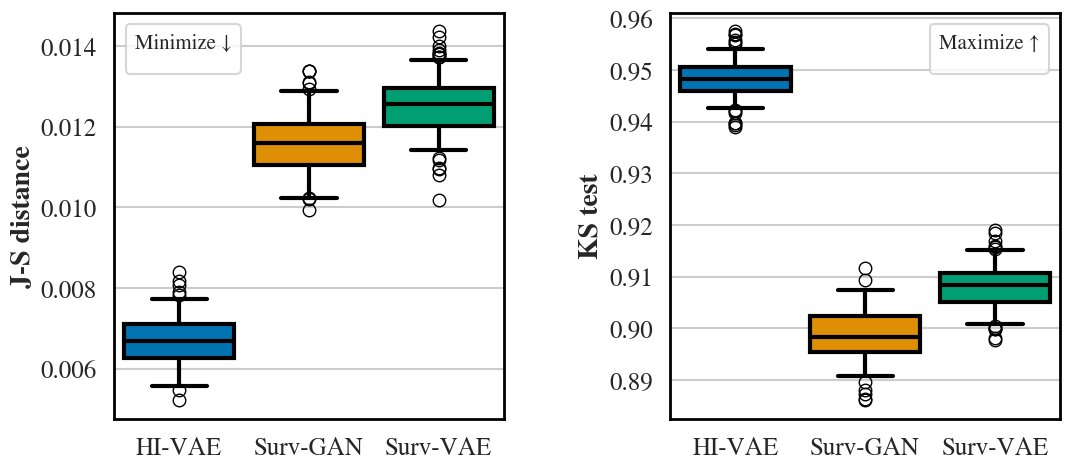

In [22]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

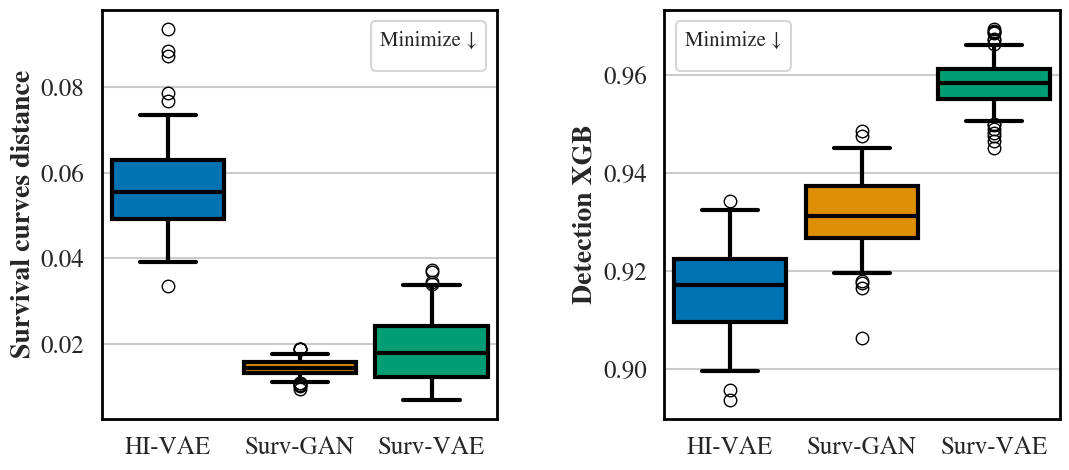

In [23]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

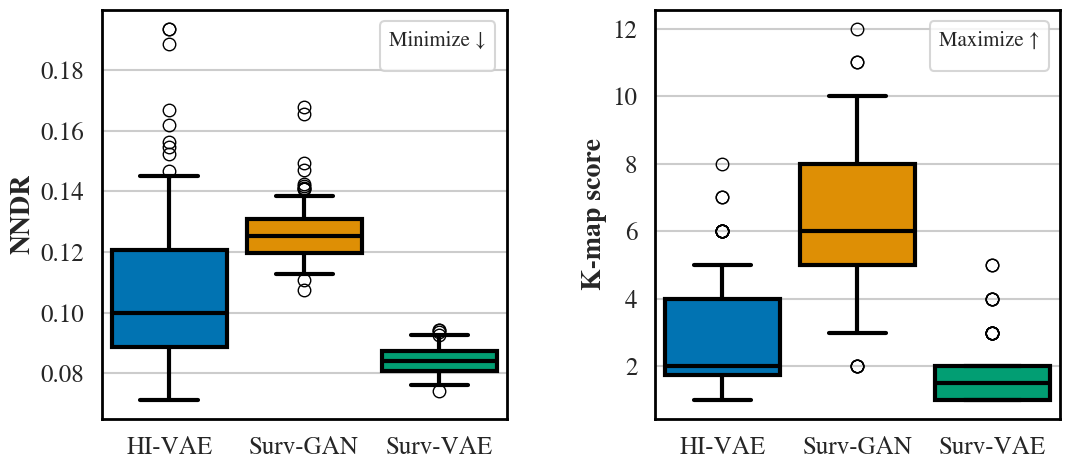

In [24]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [25]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

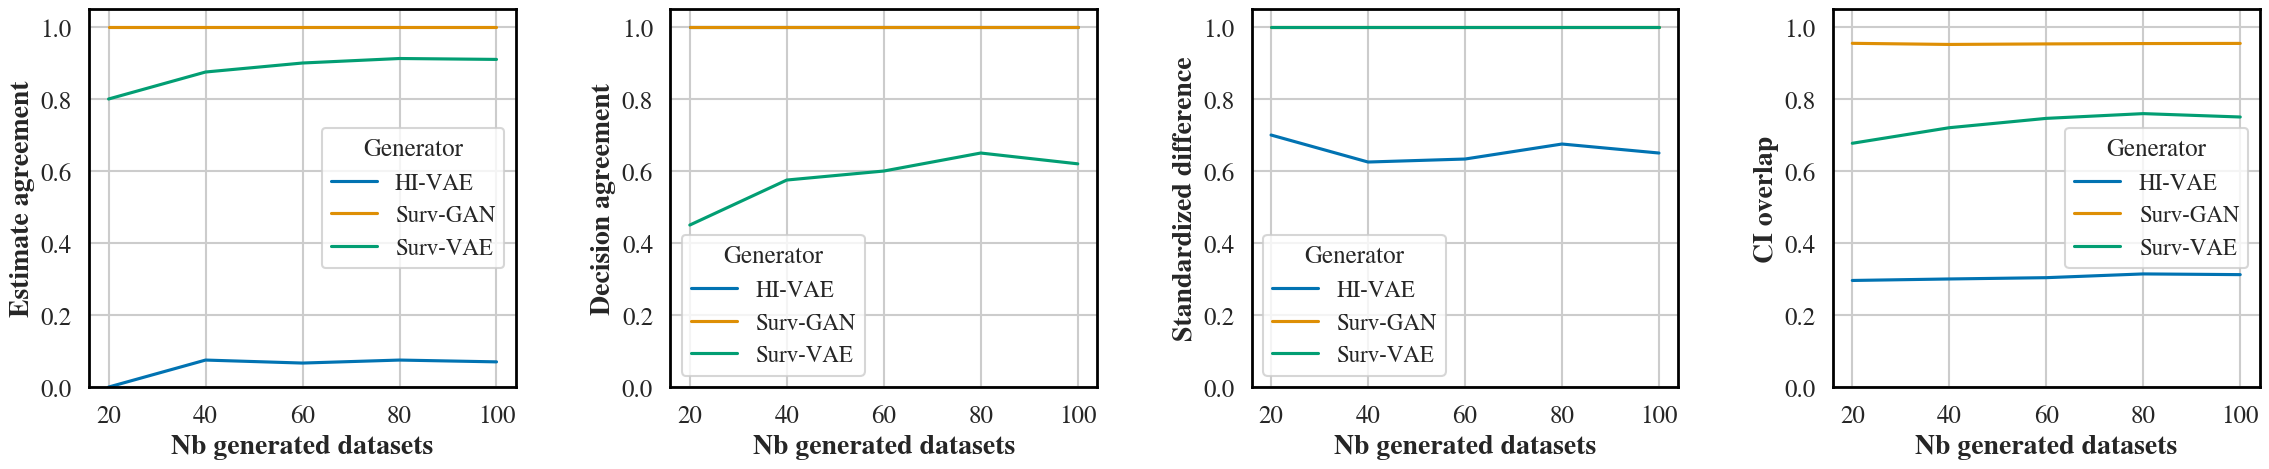

In [26]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)